In [1]:
import os
import multiprocessing as mp
import warnings

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from ActiveLearning import *
from utils import *

In [2]:
# some settings
warnings.filterwarnings('ignore')
sns.set()
% matplotlib inline

In [3]:
# input data should put in this working directory, which in the same directory level with "active_learning/",
# and all results including images and Doc2Vec model will output to this working directory

# input data should be a CSV file and include two columns, 
## "text": raw text data
## "label": annotation

work_dir = '../sms_spam_50/'

In [4]:
filename = os.path.join(work_dir, 'data.csv')
data = pd.read_csv(filename, index_col=None, header=0).dropna()
X_raw = data.text.values
y = data.label.values
tfidf_vectorizer = TfidfVectorizer(analyzer=tokenize)
X = tfidf_vectorizer.fit_transform(X_raw).toarray()

In [5]:
count_vectorizer = CountVectorizer(analyzer=tokenize)
X_count = count_vectorizer.fit_transform(X_raw).toarray()
total_count = np.sum(X_count, axis=0)
total_count.shape

(5490,)

In [6]:
X = X[:, total_count > 1]

In [7]:
X.shape

(1500, 2676)

In [8]:
y[y==1].shape[0] / y.shape[0]

0.498

In [9]:
k_fold = 5
num_iter = -1 # this means to iterate all data
models = ['RandomSVM', 'EnumerateSVM', 'RandomSwitchEnumerateSVM']
num_model = len(models)

In [10]:
def experiment_for_mp(model_name):
    return experiment(model_name, X, y, num_iter=num_iter, k_fold=k_fold)
with mp.Pool(len(models)) as pool:
    res = pool.map(experiment_for_mp, models)

RandomSVM: 1:71.50[sec] 2:68.75[sec] 3:66.73[sec] 4:68.73[sec] 5:72.24[sec] 
RandomSwitchEnumerateSVM: 1:72.34[sec] 2:81.40[sec] 3:72.39[sec] 4:68.20[sec] 5:62.89[sec] 
EnumerateSVM: 1:86.07[sec] 2:77.70[sec] 3:85.42[sec] 4:78.45[sec] 5:48.66[sec] 


In [11]:
titles = ['acc', 'recall', 'precision', 'f1', 
          'current_acc', 'current_recall', 'current_precision', 'current_f1',
          'unlabeled_acc', 'unlabeled_recall', 'unlabeled_precision', 'unlabeled_f1',
          'pos_coverage', 'labeled_prop', 'recent_prop', 'unlabeled_prop']
labels = ['Random Sampling', 'Target Extraction', 'Random Starter']
linestyles = [':', '--', '-', ':']
colors = ['r', 'g', 'b', 'orange']
img_format = '.eps'
colormap = 'gnuplot'

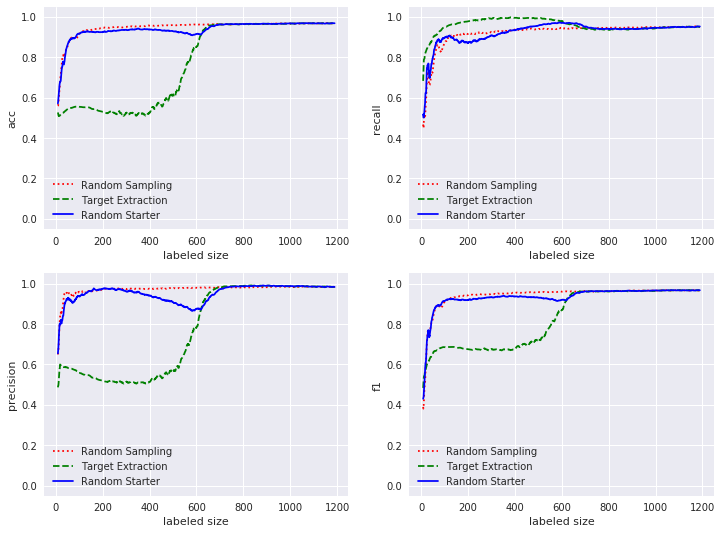

In [12]:
plt.figure(figsize=(12, 9))

for i, key in enumerate(titles[0:4]):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_xlabel('labeled size')
    ax.set_ylabel(key)
    ax.set_ylim((-0.05, 1.05))
    
    for j in range(num_model):
        ax.plot(pd.Series(np.mean([x[key] for x in res[j]], axis=0)).rolling(10).mean(), color=colors[j], linestyle=linestyles[j], label=labels[j])

    ax.legend(loc='best')

plt.savefig(os.path.join(work_dir, 'oracle' + img_format))


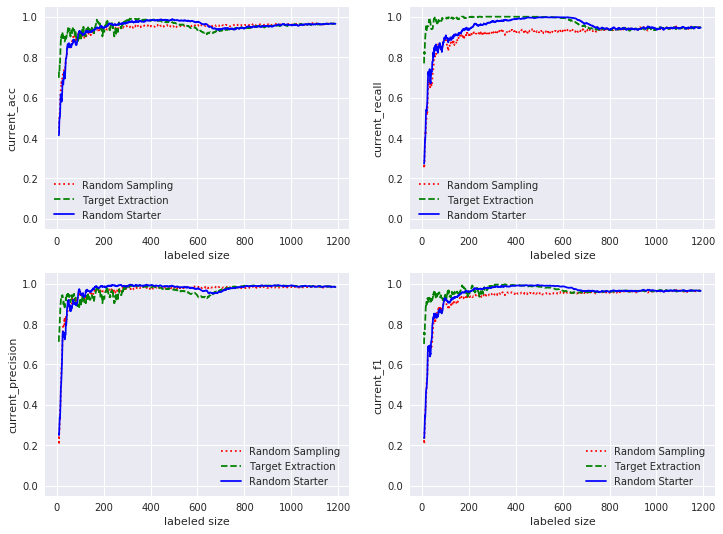

In [13]:
plt.figure(figsize=(12, 9))

for i, key in enumerate(titles[4:8]):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_xlabel('labeled size')
    ax.set_ylabel(key)
    ax.set_ylim((-0.05, 1.05))
    
    for j in range(num_model):
        ax.plot(pd.Series(np.mean([x[key] for x in res[j]], axis=0)).rolling(10).mean(), color=colors[j], linestyle=linestyles[j], label=labels[j])

    ax.legend(loc='best')

plt.savefig(os.path.join(work_dir, 'current' + img_format))


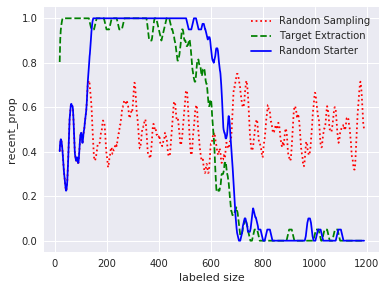

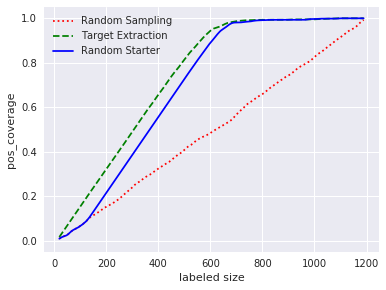

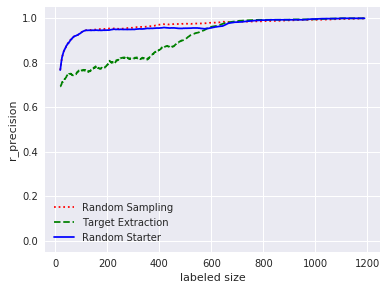

In [14]:
others = ['recent_prop', 'pos_coverage', 'r_precision']

for key in others:
    plt.figure(figsize=(6, 4.5))
    plt.ylim((-0.05, 1.05))
    plt.xlabel('labeled size')
    plt.ylabel(key)
    for j in range(num_model):
        plt.plot(pd.Series(res[j][0][key]).rolling(20).mean(), color=colors[j], linestyle=linestyles[j], label=labels[j])
    plt.legend(loc='best')
    plt.savefig(os.path.join(work_dir, key + img_format))

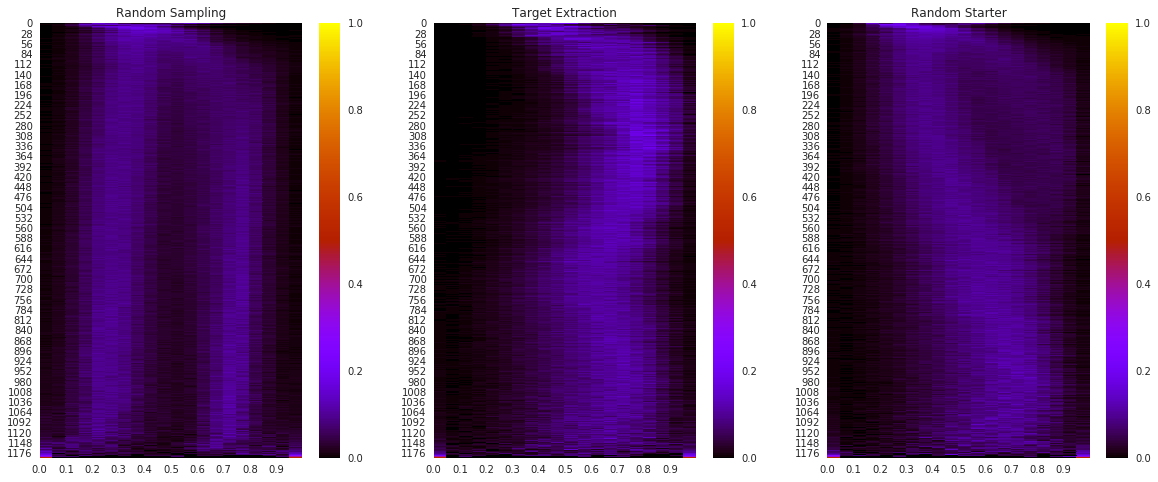

In [15]:
def hist(x):
    return np.histogram(x, range=(0, 1), bins=20)[0]

plt.figure(figsize=(20, 8))
for j in range(num_model):
    ax = plt.subplot(1, num_model, j + 1)
    ax.set_title(labels[j])
    hists = np.mean([[hist(x) / hist(x).sum() for x in res[j][i]['probas']] for i in range(5)], axis=0)
    sns.heatmap(hists, vmin=0, vmax=1, cmap=colormap)
    plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2) / 20)
    
plt.savefig(os.path.join(work_dir, 'heat_map' + img_format))

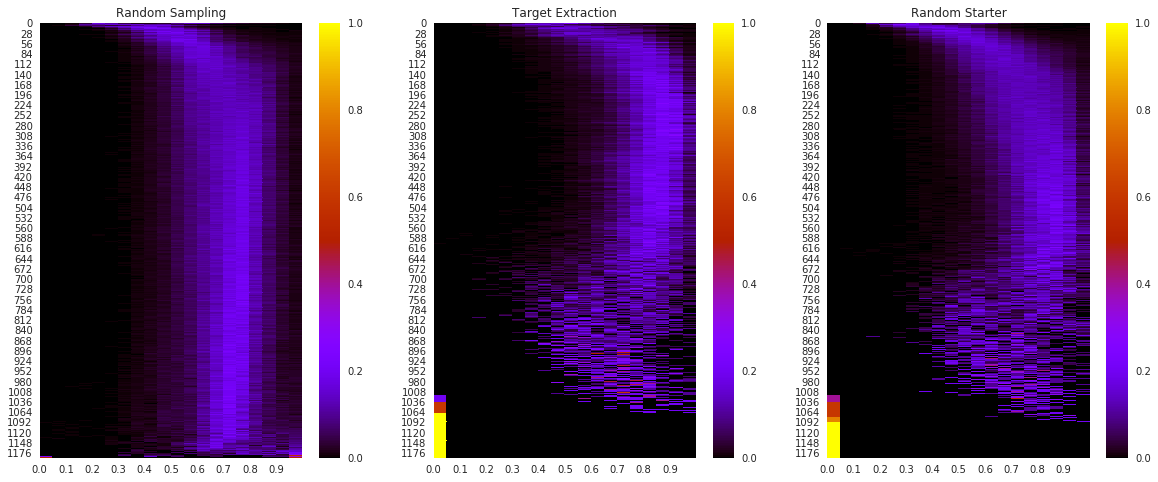

In [16]:
plt.figure(figsize=(20, 8))
for j in range(num_model):
    ax = plt.subplot(1, num_model, j + 1)
    ax.set_title(labels[j])
    hists = np.mean([[hist(x) / hist(x).sum() for x in res[j][i]['true_probas']] for i in range(5)], axis=0)
    sns.heatmap(hists, vmin=0, vmax=1, cmap=colormap)
    plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2) / 20)
    
plt.savefig(os.path.join(work_dir, 'heat_map_true' + img_format))

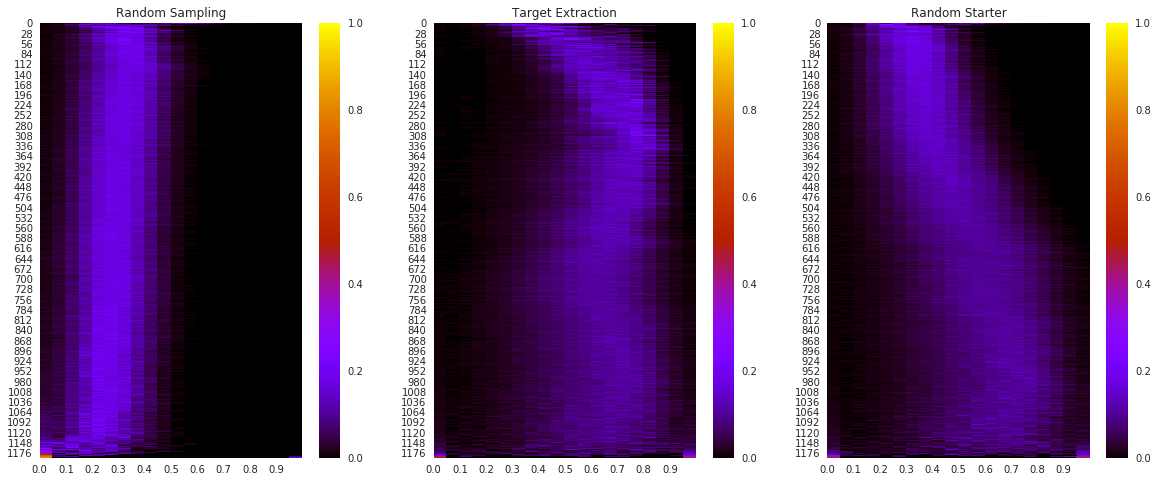

In [17]:
plt.figure(figsize=(20, 8))
for j in range(num_model):
    ax = plt.subplot(1, num_model, j + 1)
    ax.set_title(labels[j])
    hists = np.mean([[hist(x) / hist(x).sum() for x in res[j][i]['false_probas']] for i in range(5)], axis=0)
    sns.heatmap(hists, vmin=0, vmax=1, cmap=colormap)
    plt.xticks(np.arange(0, 20, 2), np.arange(0, 20, 2) / 20)
    
plt.savefig(os.path.join(work_dir, 'heat_map_false' + img_format))